Önceki bölümde, Food Vision projemizde (daha az veriyle bile olsa) kendi modellerimizi oluşturmaktan çok daha iyi sonuçlar elde etmek için özellik çıkarma aktarımı öğreniminden nasıl yararlanabileceğimizi gördük.

Şimdi başka bir transfer öğrenme türünü ele alacağız: ince ayar (Fine Tuning).

Transfer öğreniminde ince ayar yapılırken, başka bir modelden önceden eğitilmiş model ağırlıkları, kendi verilerinize daha iyi uyması için donmaz ve ince ayar yapılır.

Özellik çıkarma transferi öğrenimi için, önceden eğitilmiş bir modelin yalnızca ilk 1-3 katmanını kendi verilerinizle eğitebilirsiniz, transfer öğreniminde ince ayarda, önceden eğitilmiş bir modelin 1-3+ katmanını eğitebilirsiniz (burada '+', katmanların çoğunun veya tamamının eğitilebileceğini gösterir).

<img src="https://miro.medium.com/proxy/1*1CxVzTNILTHgDs5yJO4W9A.png" />

## Yardımcı fonksiyonlar oluşturma

Makine öğrenimi projeleriniz boyunca, muhtemelen tekrar tekrar kullanmak istediğiniz kod parçacıklarıyla karşılaşacaksınız.

Örneğin, bir modelin geçmiş nesnesini çizen bir plot işlevi: (Bu işlevleri tekrar tekrar oluşturabilirsiniz.)
```
from helper_functions import plot_loss_curves
 
...
 
plot_loss_curves(history)
```
Bunun neye benzediğini görelim.

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"TensorBoard verilerini bu klasöre kaydet: {log_dir}")
  return tensorboard_callback

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
import zipfile

def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"'{dirpath}' klasöründe {len(filenames)} veri var.")

Harika, şimdi her seferinde sıfırdan yeniden yazmak zorunda kalmadan dizüstü bilgisayar boyunca kullanabileceğimiz bir dizi yardımcı işlevimiz var.


## 10 Food Classes: Daha Az Veriyle Çalışmak

Bir önceki not defterinde, TensorFlow Hub ile transfer öğrenimini kullanarak eğitim verilerinin yalnızca %10'u ile harika sonuçlar elde edebileceğimizi görmüştük.

Bu not defterinde, verilerin daha küçük alt kümeleriyle çalışmaya devam edeceğiz, ancak bu sefer `tf.keras.applications` modülündeki yerleşik önceden eğitilmiş modellerine ve  nasıl kullanabileceğimize bir göz atacağız. Bunları kendi özel veri kümemizlee nasıl ince ayar yapabileceğimizi öğreneceğiz.

Ayrıca, `tf.keras.preprocessing` modülünün bir parçası olan `image_dataset_from_directory()` adlı daha önce kullandığımıza benzer yeni ama benzer bir veri yükleyici işlevi kullanarak alıştırma yapacağız.

Son olarak, derin öğrenme modelleri oluşturmak için [Keras Function API](https://keras.io/guides/functional_api/)'sini kullanma alıştırması da yapacağız. İşlevsel API, modeller oluşturmanın [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) API'sinden daha esnek bir yoludur.

Bunların her birini ilerledikçe daha ayrıntılı olarak inceleyeceğiz.

Bazı verileri indirerek başlayalım.

In [ ]:
# verisetini içeriye aktaralım
!gdown --id 1EJHNCG19hJG6XwIFxt2rpah-Q1Ikrbxw
unzip_data("10_food_classes_10_percent.zip")

Downloading...
From: https://drive.google.com/uc?id=1EJHNCG19hJG6XwIFxt2rpah-Q1Ikrbxw
To: /content/10_food_classes_10_percent.zip
169MB [00:02, 74.3MB/s]


İndirdiğimiz veri seti, önceki not defterinde kullandığımız eğitim görüntülerinin %10'unu içeren 10 food classes veri setidir (Food 101'den).

In [ ]:
# dosya sayısını listeleyin
walk_through_dir("10_food_classes_10_percent")

'10_food_classes_10_percent' klasöründe 0 veri var.
'10_food_classes_10_percent/train' klasöründe 0 veri var.
'10_food_classes_10_percent/train/chicken_wings' klasöründe 75 veri var.
'10_food_classes_10_percent/train/sushi' klasöründe 75 veri var.
'10_food_classes_10_percent/train/steak' klasöründe 75 veri var.
'10_food_classes_10_percent/train/pizza' klasöründe 75 veri var.
'10_food_classes_10_percent/train/ice_cream' klasöründe 75 veri var.
'10_food_classes_10_percent/train/ramen' klasöründe 75 veri var.
'10_food_classes_10_percent/train/fried_rice' klasöründe 75 veri var.
'10_food_classes_10_percent/train/chicken_curry' klasöründe 75 veri var.
'10_food_classes_10_percent/train/grilled_salmon' klasöründe 75 veri var.
'10_food_classes_10_percent/train/hamburger' klasöründe 75 veri var.
'10_food_classes_10_percent/test' klasöründe 0 veri var.
'10_food_classes_10_percent/test/chicken_wings' klasöründe 250 veri var.
'10_food_classes_10_percent/test/sushi' klasöründe 250 veri var.
'10_foo

Eğitim dizinlerinin her birinin 75 görüntü içerdiğini ve test dizinlerinin her birinin 250 görüntü içerdiğini görebiliriz.

Eğitim ve test dosya yollarımızı tanımlayalım.


In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Şimdi elimizde bir miktar görüntü verisi var, onu TensorFlow uyumlu bir formata yüklemenin bir yoluna ihtiyacımız var.

Daha önce [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) sınıfını kullandık. Ve bu iyi çalışıyor ve hala çok yaygın olarak kullanılıyor olsa da, bu sefer `image_data_from_directory` işlevini kullanacağız.

`ImageDataGenerator`'ın `flow_from_directory` yöntemiyle hemen hemen aynı şekilde çalışır, yani resimlerinizin aşağıdaki dosya biçiminde olması gerekir:

```
10_food_classes_10_percent 
└───train 
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───tes
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

`ImageDataGenerator` yerine `tf.keras.prepreprocessing.image_dataset_from_directory()` kullanmanın en önemli nedenlerinden biri, bir üreteç yerine bir `tf.data.Dataset` nesnesi oluşturmasıdır. Bunun ana avantajı, `tf.data.Dataset` API'sinin, daha büyük veri kümeleri için çok önemli olan ImageDataGenerator API'sinden çok daha verimli (daha hızlı) olmasıdır.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32) 
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Olağanüstü! Veri yükleyicilerimiz her veri kümesi için doğru sayıda görüntü bulmuş gibi görünüyor.

`image_dataset_from_directory()` işlevinde ana parametreler şunlardır:

- **directory**<br>
Görüntüleri yüklediğimiz hedef dizinin dosya yolu.
- **image_size**<br>
Yükleyeceğimiz görüntülerin hedef boyutu (yükseklik, genişlik).
- **batch_size**<br> 
Yükleyeceğimiz resimlerin toplu batch size'ı. Örneğin, toplu batch size 32 (varsayılan) ise, modele bir seferde 32 resim ve etiketten oluşan gruplar geçirilecektir.

[`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) belgelerinde gerekirse oynayabileceğimiz daha çok şey var.

Eğitim veri tipini kontrol edersek, onu verilerimizle ilgili şekiller içeren bir `BatchDataset` olarak görmeliyiz.

In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

Yukarıdaki çıktıda:

- `(None, 224, 224, 3)`, None'un batchi, 224'ün yükseklik (ve genişlik) ve 3'ün renk kanalları (kırmızı, yeşil, mavi) olduğu görüntülerimizin tensör şeklini ifade eder.
- `(None, 10)`, None'un batch sayısı ve 10'un olası etiket sayısı olduğu (10 farklı gıda sınıfı) etiketlerin tensör şeklini belirtir.
- Hem görüntü tensörleri hem de etiketler `tf.float32` veri tipindedir.

Batch_size, yalnızca model eğitimi sırasında kullanıldığından None değerine eşittir. None'un  image_dataset_from_directory()'deki batch_size parametresiyle doldurulmayı bekleyen bir yer tutucu olarak düşünebilirsiniz.

`tf.data.Dataset` API'sini kullanmanın bir başka yararı da onunla birlikte gelen ilişkili yöntemlerdir.

Örneğin çalıştığımız sınıfların adını bulmak istiyorsak `class_names` özniteliğini kullanabiliriz.

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Veya örnek bir veri yığını görmek istersek, `take()` yöntemini kullanabiliriz.

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print("image: ", images[0])
  print("label: ", labels[0])

image:  tf.Tensor(
[[[151.22958   122.28571    74.90306  ]
  [144.23979   117.45409    79.005104 ]
  [132.43367   111.36224    84.158165 ]
  ...
  [ 19.571407    7.571407    7.571407 ]
  [ 20.428585    6.4285846   6.4285846]
  [ 22.071463    8.071464    8.071464 ]]

 [[135.66327   115.30612    79.87755  ]
  [127.168365  109.602036   80.88776  ]
  [127.90306   113.10204    94.43368  ]
  ...
  [ 20.586777    7.0153046   7.0153046]
  [ 21.928572    5.9285717   6.9285717]
  [ 22.928572    6.9285717   7.9285717]]

 [[123.96429   116.82143    98.7602   ]
  [138.46939   132.19899   117.61225  ]
  [149.80103   144.08673   135.87756  ]
  ...
  [ 21.688793    5.2602215   5.2602215]
  [ 24.428572    6.          6.214286 ]
  [ 25.214287    6.785714    7.       ]]

 ...

 [[ 20.341839    9.341838    5.3418384]
  [ 23.204142   12.204142    8.204142 ]
  [ 21.04587    10.04587     8.04587  ]
  ...
  [ 52.566254   22.351992   20.137728 ]
  [ 51.214203   21.785675   17.857056 ]
  [ 57.056206   26.132736

## Model 0: Keras İşlevsel API'sini kullanarak bir aktarım öğrenme modeli oluşturma

Pekala, verilerimiz tensörlü, hadi bir model oluşturalım.

Bunu yapmak için [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) modülünü kullanacağız, çünkü bu modül zaten eğitilmiş (ImageNet'te) bir dizi bilgisayarlı görü modelinin yanı sıra modelimizi oluşturmak için Keras İşlevsel API'sini içerir.

Aşağıdaki adımları uygulayacağız:

1. `tf.keras.applications` işlevi ile `EfficientNetB0` gibi bir hedef model seçerek, `include_top` parametresini `False` olarak ayarlayarak önceden eğitilmiş bir temel model nesnesini görüntüleyin.
2. Önceden eğitilmiş modeldeki tüm ağırlıkları dondurmak için temel modelin `trainable` niteliğini `False` olarak ayarlayın.
3. Modelimiz için bir girdi katmanı tanımlayın, örneğin modelimiz hangi veri şeklini beklemelidir? (Bizim modelimiz için bu değer = (224, 224, 3) )
4. [Opsiyonel] Gerekiyorsa girdileri normalleştirin. ResNetV250 gibi bazı bilgisayarlı görme modelleri, girişlerinin 0 ve 1 arasında olması gerekir.
> 🤔 Not: Yazıldığı gibi, `tf.keras.applications`  modülündeki EfficientNet modelleri, diğer birçok modelde olduğu gibi, girişte görüntülerin normalleştirilmesini (0 ile 1 arasındaki piksel değerleri) gerektirmez. 

5. Girdileri temel modele iletin.
6. Temel modelin çıktılarını, çıktı etkinleştirme katmanıyla uyumlu bir şekle toplayın (temel model çıktı tensörlerini etiket tensörleriyle aynı şekle çevirin). Bu, `tf.keras.layers.GlobalAveragePooling2D()` veya t`f.keras.layers.GlobalMaxPooling2D()` kullanılarak yapılabilir, ancak ilki pratikte daha yaygındır.
7. Uygun aktivasyon fonksiyonu ve nöron sayısı ile `tf.keras.layers.Dense()` kullanarak bir çıktı aktivasyon katmanı oluşturun.
8. `tf.keras.Model()` kullanarak girdi ve çıktı katmanını bir modelde birleştirin.
9. Uygun kayıp fonksiyonunu kullanarak modeli derleyin ve optimize ediciyi seçin.
10. Modeli istenen sayıda batch ve gerekli callback için fit edin (bizim durumumuzda, TensorBoard callback'i ile başlayacağız).

In [ ]:
# 1.adım
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2.adım
base_model.trainable = False

# 3.adım
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4.adım
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5.adım
x = base_model(inputs)
print(f"base_model'den sonraki şekil: {x.shape}")

# 6.adım
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"GlobalAveragePooling2D() sonraki şekil: {x.shape}")

# 7.adım
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8.adım
model_0 = tf.keras.Model(inputs, outputs)

# 9.adım
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10.adım
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16711680/16705208 [==============================] - 0s 0us/step
base_model'den sonraki şekil: (None, 7, 7, 1280)
GlobalAveragePooling2D() sonraki şekil: (None, 1280)
TensorBoard verilerini bu klasöre kaydet: transfer_learning/10_percent_feature_extract/20210720-051625


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 46s 448ms/step - loss: 1.8824 - accuracy: 0.4133 - val_loss: 1.2809 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 8s 326ms/step - loss: 1.1362 - accuracy: 0.7440 - val_loss: 0.8795 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 8s 326ms/step - loss: 0.8402 - accuracy: 0.8000 - val_loss: 0.7170 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 6s 216ms/step - loss: 0.6891 - accuracy: 0.8427 - val_loss: 0.6364 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 5s 212ms/step - loss: 0.5935 - accuracy: 0.8560 - val_loss: 0.5980 - val_accuracy: 0.8618


Güzel! Yaklaşık bir dakikalık eğitimden sonra modelimiz hem eğitim (%87+ doğruluk) hem de test setlerinde (~%83 doğruluk) inanılmaz derecede iyi performans gösteriyor Hepsi transfer öğrenmenin gücü sayesinde.

TensorFlow Hub modellerinde yaptığımıza benzer şekilde, burada kullandığımız transfer öğrenimi türünün özellik çıkarma transfer öğrenimi olarak adlandırıldığını not etmek önemlidir.

Başka bir deyişle, özel verilerimizi önceden eğitilmiş bir modele (EfficientNetB0) ilettik ve "hangi kalıpları görüyorsunuz?" diye sorduk. Ve ardından çıktıların istediğimiz sınıf sayısına göre uyarlandığından emin olmak için kendi çıktı katmanımızı en üste koyduk.

Modelimizi oluşturmak için Sıralı API yerine Keras İşlevsel API'sini de kullandık. Şimdilik, bu ana yöntemin faydaları net görünmüyor, ancak daha karmaşık modeller oluşturmaya başladığınızda, muhtemelen İşlevsel API'yi kullanmak isteyeceksiniz. Bu nedenle, bu model oluşturma yöntemine bilmeniz önemlidir.

> 📖 Kaynak: Sıralı API'ye karşı İşlevsel API'nin faydalarını ve kullanım örneklerini görmek için TensorFlow [İşlevsel API belgelerine](https://www.tensorflow.org/guide/keras/functional) bakın.

Modelimizdeki katmanları inceleyelim:

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

Çok fazla katman var... bunların hepsini elle kodlamak oldukça uzun zaman alacaktı, yine de transfer öğrenmenin gücü sayesinde bunlardan faydalanabiliriz.

base_model'in bir özetine ne dersiniz?

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

Genel modelimiz beş katmana sahiptir, ancak gerçekte bu katmanlardan biri `(efficientnetb0)` 236 katmana sahiptir.

Çıktı şeklinin giriş katmanı (resimlerimizin şekli) için (None, 224, 224, 3) olarak nasıl başladığını, ancak çıktı katmanı (etiketlerimizin şekli) tarafından (None, 10) olarak nasıl dönüştürüldüğünü görebilirsiniz. ), burada None, batch boyutu için yer tutucudur. Modeldeki eğitilebilir parametreler yalnızca çıktı katmanındaki parametrelerdir.

Modelimizin eğitim eğrileri nasıl görünüyor?

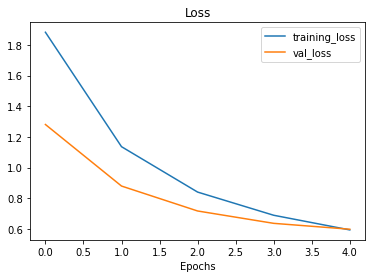

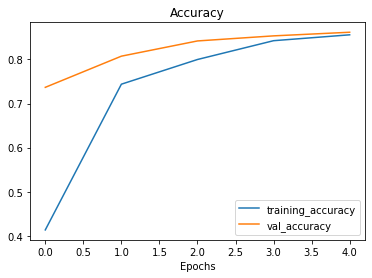

In [ ]:
plot_loss_curves(history_10_percent)

## Eğitilmiş Bir Modelden Özellik Vektörü Alma

> 🤔 Soru: tf.keras.layers.GlobalAveragePooling2D() katmanını da ne? Daha önce görmedim.

[`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) katmanı, iç eksenlerdeki değerlerin ortalamasını alarak 4B tensörü 2B tensöre dönüştürür.

Yukarıda ki tanım biraz karmaşık gibi, o yüzden bir örnek görelim.


In [ ]:
# Giriş tensör şeklini tanımlayın 
input_shape = (1, 4, 4, 3)

# random bir tensör oluşturun
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# rastgele tensörü global average pooling 2D katmanından geçirin
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Tensörlerin şekillerini kontrol edin
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


`tf.keras.layers.GlobalAveragePooling2D()` katmanının giriş tensörünü (1, 4, 4, 3) şeklinden (1, 3) şekline değiştiğini görebilirsiniz. Bunu, ortadaki iki eksen boyunca `input_tensor`'un ortalamasını alarak yaptı.

Bu işlemi `tf.reduce_mean()` işlevini kullanarak ve uygun eksenleri belirleyerekte çoğaltabiliriz.

In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Bunu yapmak, yalnızca temel modelin çıktısını, çıktı katmanımızın (tf.keras.layers.Dense()) girdi şekli gereksinimi ile uyumlu hale getirmekle kalmaz, aynı zamanda temel model tarafından bulunan bilgiyi daha düşük boyutlu bir özellik vektöründe yoğunlaştırır.

> 🔑 Not: Özellik çıkarma transfer öğreniminin nasıl olduğu olarak adlandırılmasının nedenlerinden biri, önceden eğitilmiş bir modelin bir özellik vektörü vermesidir (bizim durumumuzda bu, [tf.keras.Layer.GlobalAveragePooling2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)  katmanı çıktısıdır.), daha sonra kalıpları çıkarmak için kullanılabilir.

> 🛠 Alıştırma: Yukarıdaki hücreyle aynısını yapın, ancak [tf.keras.layers.GlobalMaxPool2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D) için.

## Transfer Learning Deneylerini Çalıştırma

Eğitim verilerinin %10'unda transfer öğreniminin inanılmaz sonuçlarını gördük, peki ya eğitim verilerinin %1'i?

Kendi yaptığımız orijinal CNN modellerinden 100 kat daha az veri kullanarak ne tür sonuçlar elde edebileceğimizi düşünüyorsunuz?

Aşağıdaki modelleme deneylerini çalıştırırken neden bu soruyu yanıtlamıyoruz:

- `model_1` : Veri büyütme ile eğitim verilerinin %1'inde özellik çıkarma aktarımı öğrenimini kullanın.
- `model_2`: Veri büyütme ile eğitim verilerinin %10'unda özellik çıkarma aktarımı öğrenimini kullanın.
- `model_3`: Veri artırma ile eğitim verilerinin %10'unda transfer öğrenimini ince ayar kullanarak kullanın.
- `model_4`: Veri büyütme ile eğitim verilerinin %100'ünde transfer öğrenimi ince ayarını kullanın.

Tüm deneyler, eğitim verilerinin farklı versiyonları üzerinde yürütülecek olsa da, hepsi aynı test veri setinde değerlendirilecek ve bu, her deneyin sonuçlarının mümkün olduğunca karşılaştırılabilir olmasını sağlar.

Tüm deneyler tf.keras.applications modülü içerisinde **EfficientNetB0** modeli kullanılarak yapılacaktır.

Deneylerimizi takip ettiğimizden emin olmak için tüm model eğitim günlüklerini günlüğe kaydetmek için `create_tensorboard_callback()` işlevimizi kullanacağız.

Her modeli Keras Functional API kullanarak oluşturacağız ve daha önce yaptığımız gibi `ImageDataGenerator` sınıfında veri büyütmeyi uygulamak yerine, onu `tf.keras.layers.experimental.preprocessing` modülünü kullanarak doğrudan modelin içine inşa edeceğiz.

Veri büyütmeli eğitim verilerinin %1'inde özellik çıkarma aktarımı öğrenimini kullanarak deney_1 için verileri indirerek başlayalım.

In [ ]:
# verisetini içeriye aktaralım
!gdown --id 1B76twu4qxiFcRrTRwxJnRgZd7sC_Q3Gv
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

Downloading...
From: https://drive.google.com/uc?id=1B76twu4qxiFcRrTRwxJnRgZd7sC_Q3Gv
To: /content/10_food_classes_1_percent.zip
134MB [00:01, 90.6MB/s]


In [ ]:
walk_through_dir("10_food_classes_1_percent")

'10_food_classes_1_percent' klasöründe 0 veri var.
'10_food_classes_1_percent/train' klasöründe 0 veri var.
'10_food_classes_1_percent/train/chicken_wings' klasöründe 7 veri var.
'10_food_classes_1_percent/train/sushi' klasöründe 7 veri var.
'10_food_classes_1_percent/train/steak' klasöründe 7 veri var.
'10_food_classes_1_percent/train/pizza' klasöründe 7 veri var.
'10_food_classes_1_percent/train/ice_cream' klasöründe 7 veri var.
'10_food_classes_1_percent/train/ramen' klasöründe 7 veri var.
'10_food_classes_1_percent/train/fried_rice' klasöründe 7 veri var.
'10_food_classes_1_percent/train/chicken_curry' klasöründe 7 veri var.
'10_food_classes_1_percent/train/grilled_salmon' klasöründe 7 veri var.
'10_food_classes_1_percent/train/hamburger' klasöründe 7 veri var.
'10_food_classes_1_percent/test' klasöründe 0 veri var.
'10_food_classes_1_percent/test/chicken_wings' klasöründe 250 veri var.
'10_food_classes_1_percent/test/sushi' klasöründe 250 veri var.
'10_food_classes_1_percent/test/

Pekala, her sınıftan yalnızca yedi resmimiz var gibi görünüyor, bu modelimiz için biraz zor olmalı.

> 🔑 Not: Veri alt kümesinin %10'unda olduğu gibi, görüntülerin %1'i orijinal tam eğitim veri kümesinden rastgele seçilmiştir.

Resimlerimizi `tf.data.Dataset` nesneleri olarak yükleme zamanı, bunu yapmak için `image_dataset_from_directory()` yöntemini kullanacağız.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Doğrudan modele veri büyütme ekleme

Daha önce eğitim görüntülerimizi güçlendirmek için `ImageDataGenerator` sınıfının farklı parametrelerini kullandık, bu sefer doğrudan modelin içine veri büyütmeyi inşa edeceğiz.

Nasıl?

`tf.keras.layers.experimental.preprocessing` modülünü kullanarak ve özel bir veri büyütme katmanı kullanarak.

Bu, TensorFlow 2.2+ sürümüne eklenen nispeten yeni bir özelliktir ancak çok güçlüdür. Modele bir veri büyütme katmanı eklemek aşağıdaki avantajlara sahiptir:

- Görüntülerin ön işlemesi (artırılması) CPU yerine GPU'da gerçekleşir (çok daha hızlı).
  - Görüntüler en iyi GPU'da ön işlenirken, metin ve yapılandırılmış veriler CPU'da önişlenmeye daha uygundur.
- Görüntü verisi büyütme yalnızca eğitim sırasında gerçekleşir, bu nedenle tüm modelimizi dışa aktarabilir ve başka bir yerde kullanabiliriz.

> 🤔 Not: Yazma sırasında, veri büyütme için kullandığımız ön işleme katmanları, TensorFlow kitaplığında deneysel durumda. Bu, katmanların kararlı olarak kabul edilmesi gerekmesine rağmen, TensorFlow'un gelecekteki bir sürümünde kodun biraz değişebileceği anlamına gelir. Mevcut diğer ön işleme katmanları ve farklı veri artırma yöntemleri hakkında daha fazla bilgi için [Keras ön işleme katmanları kılavuzuna](https://keras.io/guides/preprocessing_layers/) ve [TensorFlow veri artırma kılavuzuna](https://www.tensorflow.org/tutorials/images/data_augmentation) bakın.


Veri büyütmeyi doğrudan modelimizde kullanmak için, yalnızca veri ön işleme katmanlarından oluşan bir Keras Sıralı modeli oluşturacağız, daha sonra bu Sıralı modeli başka bir işlevsel model içinde kullanabiliriz.

Bu kafa karıştırıcı geliyorsa, kodda oluşturduğumuzda mantıklı olacaktır.

Kullanacağımız veri büyütme dönüşümleri şunlardır:

- `RandomFlip` - görüntüyü yatay veya dikey eksende döndürür.
- `RandomRotation` - görüntüyü belirli bir miktarda rastgele döndürür.
- `RandomZoom` - bir görüntüyü belirtilen miktarda rastgele yakınlaştırır.
- `RandomHeight` - görüntü yüksekliğini belirli bir miktarda rastgele kaydırır.
- `RandomWidth` - görüntü genişliğini belirli bir miktarda rastgele kaydırır.
- `Rescaling` - görüntü piksel değerlerini 0 ile 1 arasında olacak şekilde normalleştirir, bazı görüntü modelleri için gerekli olduğundan ancak EfficientNetB0'ın tf.keras.applications uygulamasını kullandığımızdan bu gerekli değildir.

Daha fazla özellik var ama şimdilik bunlar yeterli.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255)
], name ="data_augmentation")

Ve bu kadar! Veri büyütme Sıralı modelimiz kullanıma hazır. Birazdan göreceğiniz gibi, bunu daha sonra transfer öğrenme modelimize bir katman olarak yerleştirebileceğiz.

Ama bunu yapmadan önce, içinden rastgele görüntüler seçerek test edelim.

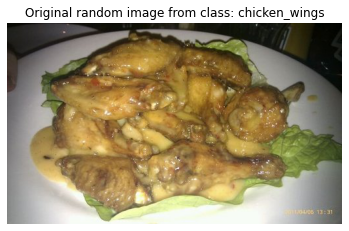

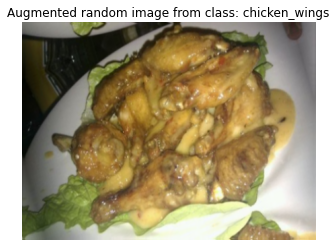

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # random bir class seçme
target_dir = "10_food_classes_1_percent/train/" + target_class # bir hedef dizini oluşturma
random_image = random.choice(os.listdir(target_dir)) # random bir görüntüyü etikeye bağlı olarak seçme
random_image_path = target_dir + "/" + random_image # seçilen rastgele görüntünün yolu oluşturma
img = mpimg.imread(random_image_path) # seçilen hedef görüntüyü okuma
plt.imshow(img) 

plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) 
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Yukarıdaki kod bloğunu birkaç kez çalıştırın ve farklı görüntü sınıflarında farklı rastgele büyütmeleri görebilirsiniz. Gelecek transfer öğrenme modelimizde veri büyütme modelini bir katman olarak ekleyeceğimiz için, içinden geçen eğitim görüntülerinin her birine bu tür rastgele büyütmeler uygulayacaktır.

Bunu yapmak, eğitim veri setimizi biraz daha çeşitli hale getirecektir. Gerçek hayatta bir yemek fotoğrafı çekiyormuşsunuz gibi düşünebilirsiniz, görüntülerin hepsi mükemmel olmayacak, bazıları garip şekillerde yönlendirilecek. Bunlar, modelimizin işlemesini istediğimiz türden görüntüler.

### Model 1: Veri Büyütme ile Verilerin %1'inde Özellik Çıkarma 

In [ ]:
# input şekli base_model olarak ayarların, base_model'in katmanlarını dondurun
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# input katmanı yaratın
inputs = layers.Input(shape=input_shape, name="input_layer")

# Veri büyütme sıralı modelini katman olarak ekleyin
x = data_augmentation(inputs)

# Base_model girdilerini verin (büyütmeden sonra) ama onu eğitmeyin
x = base_model(x, training=False)

# base modelin pooling output özellikleri
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# output olarak yoğun bir katman koyun
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Girdileri ve çıktıları olan bir model oluşturun
model_1 = keras.Model(inputs, outputs)

# modeli derleyin
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# modeli fit edin
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)),
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

TensorBoard verilerini bu klasöre kaydet: transfer_learning/1_percent_data_aug/20210720-051748


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4057 - accuracy: 0.0429 - val_loss: 2.2374 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1606 - accuracy: 0.1571 - val_loss: 2.1274 - val_accuracy: 0.2516
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9891 - accuracy: 0.3000 - val_loss: 1.9951 - val_accuracy: 0.3503
Epoch 4/5
3/3 [==============================] - 3s 2s/step - loss: 1.7833 - accuracy: 0.4714 - val_loss: 1.9065 - val_accuracy: 0.4161
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6344 - accuracy: 0.7143 - val_loss: 1.8110 - val_accuracy: 0.4770


Sınıf başına yalnızca 7 eğitim görüntüsü kullanarak, transfer öğrenmeyi kullanarak modelimiz doğrulama setinde ~%40 doğruluk elde edebildi. Orijinal Food-101 belgesi tüm verilerle, yani sınıf başına 750 eğitim görüntüsü ile %50,67 doğruluk elde ettiğinden bu sonuç oldukça şaşırtıcıdır.

Modelimizin bir özetini kontrol edersek, girdi katmanından hemen sonra veri büyütme katmanını görmeliyiz.

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


İşte burada. Artık doğrudan modelimizin içine yerleştirilmiş veri büyütmeye sahibiz. Bu, onu kaydedip başka bir yere yeniden yüklesek, veri artırma katmanlarının da onunla birlikte geleceği anlamına gelir.

Hatırlanması gereken önemli şey, veri artırmanın yalnızca eğitim sırasında çalıştığıdır. Dolayısıyla, modelimizi çıkarım için değerlendirecek veya kullanacak olursak (bir görüntünün sınıfını tahmin ederek) veri büyütme katmanları otomatik olarak kapatılacaktır.

Bunu çalışırken görmek için modelimizi test verileri üzerinden değerlendirelim.

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 120ms/step - loss: 1.8225 - accuracy: 0.4588


[1.8224549293518066, 0.45879998803138733]

Buradaki sonuçlar, eğitim sırasında modelimizin günlük çıktılarından biraz daha iyi/daha kötü olabilir, çünkü eğitim sırasında modelimizi validation_steps=int(0.25 * len(test_data)) satırını kullanarak test verilerinin yalnızca %25'i üzerinde değerlendiririz. Bunu yapmak epoch'u hızlandırır ama yine de bize modelimizin nasıl gittiğine dair yeterince fikir verir.

Tutarlı kalalım ve modelimizin kayıp eğrilerini kontrol edelim.


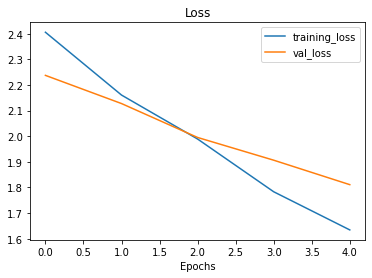

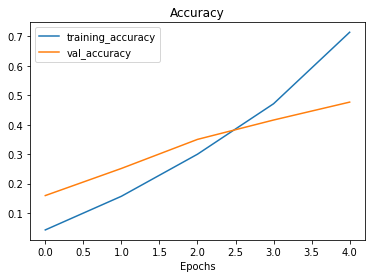

In [ ]:
plot_loss_curves(history_1_percent)

Daha fazla epoch için eğitime devam edersek, her iki veri kümesindeki metrikler de iyileşecek gibi görünüyor. Ama şimdilik bunu bırakalım, yapacak daha çok işimiz var!

### Model 2: %10 Veri ve Veri Büyütme İle Özellik Çıkarma

Pekala, veri artırma ile eğitim verilerinin %1'ini test ettik, veri artırma ile verilerin %10'unu denemeye ne dersiniz?

Fakat bekle...

> 🤔 Soru: Hangi deneyleri çalıştıracağınızı nereden biliyorsunuz?

Harika bir soru.

Buradaki gerçek şu ki, çoğu zaman bunu bilemeyeceksiniz. Makine öğrenimi hala çok deneysel bir uygulamadır. Sadece birkaç şeyi denedikten sonra, ne denemeniz gerektiğine dair bir sezgi geliştirmeye başlayacaksınız.

Benim tavsiyem, merakınızı mümkün olduğunca inatla takip etmenizdir. Bir şey denemek istediğinizi düşünüyorsanız, kodunu yazın ve çalıştırın. Nasıl gittiğini gör. Olabilecek en kötü şey, neyin işe yaramadığını, en değerli bilgi türünü bulmanızdır.

Pratik açıdan, daha önce bahsettiğimiz gibi, ilk deneyleriniz arasındaki süreyi mümkün olduğunca azaltmak isteyeceksiniz. Başka bir deyişle, umut verici bir şey bulmadan önce daha az veri ve daha az eğitim yinelemesi kullanarak çok sayıda daha küçük deney yapın ve ardından ölçeği büyütün.

Ölçek temasında, %1 eğitim verisi artırma denememizi %10 eğitim verisi artırımına kadar ölçeklendirelim. Bu cümle pek mantıklı değil ama ne demek istediğimi anladınız.

Önceki modelle tamamen aynı adımları uygulayacağız, tek fark eğitim verilerinin %1 yerine %10'unu kullanmaktır.

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Harika! Çalışmak için 10 kat daha fazla görselimiz var, sınıf başına 7 yerine sınıf başına 75.

Veri büyütmenin yerleşik olduğu bir model oluşturalım. Daha önce oluşturduğumuz veri büyütme Sıralı modelini yeniden kullanabiliriz, ancak pratik yapmak için yeniden oluşturacağız.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
], name="data_augmentation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer") 
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### ModelCheckpoint ile Callback Oluşturma

Modelimiz derlenmiş ve fit olmaya hazır, peki neden hala çalıştırmadık?

Pekala, bu deney için yeni bir callback'i, ModelCheckpoint callback'ini tanıtacağız.

[ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback'i, modelinizi bir bütün olarak [SavedModel](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) biçiminde veya ağırlıkları (kalıplar) yalnızca eğitilirken belirli bir dizine kaydetme yeteneği verir.

Modelinizin uzun süre eğitim göreceğini düşünüyorsanız ve eğitim sırasında yedeklerini almak istiyorsanız bu yararlıdır. Bu aynı zamanda, modelinizin daha uzun süre eğitilmesinden yararlanabileceğini düşünüyorsanız, belirli bir kontrol noktasından yeniden yükleyebilir ve oradan eğitime devam edebilirsiniz.

Örneğin, 5 dönem için bir özellik çıkarma transferi öğrenme modeline uyduğunuzu ve eğitim eğrilerini kontrol ettiğinizi ve hala iyileştiğini gördüğünüzü ve başka bir 5 dönem için ince ayarın yardımcı olup olmayacağını görmek istediğinizi varsayalım, kontrol noktasını yükleyebilir, dondurabilirsiniz. temel model katmanlarının bir kısmını (veya tamamını) ve ardından eğitime devam edin.

Aslında, yapacağımız şey tam olarak bu.

Ama önce bir ModelCheckpoint callbackini oluşturalım. Bunu yapmak için, kaydetmek istediğimiz bir dizini belirtmeliyiz.

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", 
                                                         verbose=1)

> 🤔 Soru: Tüm modeli kaydetme (SavedModel biçimi) ile yalnızca ağırlıkları kaydetme arasındaki fark nedir?

SavedModel formatı, bir modelin mimarisini, ağırlıklarını ve eğitim yapılandırmasını tek bir klasöre kaydeder. Modelinizi tam olarak başka bir yerde olduğu gibi yeniden yüklemenizi çok kolaylaştırır. Ancak, tüm bu ayrıntıları başkalarıyla paylaşmak istemiyorsanız, yalnızca ağırlıkları kaydedip paylaşmak isteyebilirsiniz (bunlar yalnızca insan tarafından yorumlanamayan sayıların büyük tensörleri olacaktır). Disk alanı bir sorunsa, yalnızca ağırlıkları kaydetmek daha hızlıdır ve tüm modeli kaydetmekten daha az yer kaplar.

Daha sonra ince ayar yapacağımız için, bir initial_epochs değişkeni oluşturacağız ve daha sonra kullanmak üzere 5'e ayarlayacağız. Ayrıca checkpoint_callback'imizi geri arama listemize ekleyeceğiz.

In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

TensorBoard verilerini bu klasöre kaydet: transfer_learning/10_percent_data_aug/20210720-052655
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 24s 738ms/step - loss: 1.9837 - accuracy: 0.3427 - val_loss: 1.4756 - val_accuracy: 0.6727

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 11s 460ms/step - loss: 1.3512 - accuracy: 0.6787 - val_loss: 1.0259 - val_accuracy: 0.7796

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 13s 542ms/step - loss: 1.0439 - accuracy: 0.7373 - val_loss: 0.8319 - val_accuracy: 0.8092

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 12s 489ms/step - loss: 0.8858 - accuracy: 0.7840 - val_loss: 0.7018 - val_accuracy: 0.8339

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 528ms/step - loss: 0.7971 - accuracy: 0.8013 - val_

Şuna bakar mısın! Görünüşe göre ModelCheckpoint geri aramamız işe yaradı ve modelimiz her epoch'ta çok fazla ek yük olmadan ağırlıklarını kurtardı (tüm modeli kaydetmek yalnızca ağırlıklardan daha uzun sürüyor).

Modelimizi değerlendirelim ve kayıp eğrilerini kontrol edelim.

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 116ms/step - loss: 0.6898 - accuracy: 0.8188


[0.6897677183151245, 0.8187999725341797]

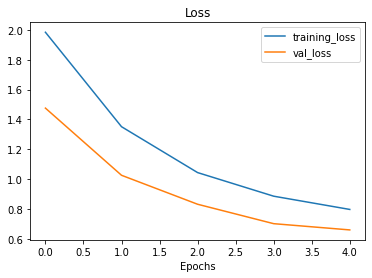

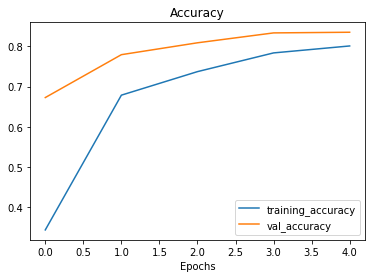

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

Bunlara bakıldığında, modelimizin %10 veri ve veri büyütme ile performansı, veri artırma olmadan %10 veri içeren model kadar iyi değil (yukarıdaki model_0 sonuçlarına bakın), ancak eğriler doğru yönde ilerliyor, yani daha uzun süre antrenman yapmaya karar verirsek, metrikleri muhtemelen iyileşir.

Kaydedilmiş model ağırlıklarını yüklemek için [load_weights()](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) yöntemini kullanabilirsiniz ve bu yöntemi, kaydedilmiş ağırlıklarınızın depolandığı yola iletebilirsiniz.

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 10s 116ms/step - loss: 0.6898 - accuracy: 0.8188


Şimdi daha önce eğitilmiş modelimiz ile yüklenen modelin sonuçlarını karşılaştıralım. Bu sonuçlar tam olarak aynı olmasa da çok yakın olmalıdır. Küçük farklılıkların nedeni, hesaplanan sayıların kesinlik düzeyinden kaynaklanmaktadır.

In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
import numpy as np

print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


### Model 3: Verilerin %10'unda Mevcut Bir Modelde İnce Ayar Yapma (Fine Tuning)

Şimdiye kadar kaydedilen modelimiz, eğitim verilerinin %10'u ve veri artırma üzerinde 5 epoch boyunca özellik çıkarma aktarımı öğrenimi kullanılarak eğitildi.

Bu, temel modeldeki (EfficientNetB0) tüm katmanların eğitim sırasında dondurulduğu anlamına gelir.

Bir sonraki denememiz için transfer öğreniminin ince ayarına geçeceğiz. Bu, bazı katmanlarını (üste en yakın olanları) çözmemiz ve modeli birkaç dönem daha çalıştırmamız dışında aynı temel modeli kullanacağımız anlamına gelir.

İnce ayar fikri, önceden eğitilmiş modeli kendi verilerimize göre daha fazla özelleştirmeye başlamaktır.

> 🔑 Not: İnce ayar genellikle en iyi, birkaç epoch için ve büyük miktarda veri içeren bir özellik çıkarma modelini eğittikten sonra çalışır.

Yüklenen modelimizin performansını doğruladık, katmanlarına bir göz atalım.

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

İyi görünüyor. Bir girdi katmanına, bir Sıralı katmana (veri artırma modeli), bir İşlevsel katmana (EfficientNetB0), bir havuz katmanına ve bir Yoğun katmana (çıkış katmanı) sahibiz.

Bir özete ne dersiniz?

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Pekala, `efficientnetb0` katmanındaki tüm katmanlar donmuş gibi görünüyor. Bunu `trainable_variables` niteliğini kullanarak onaylayabiliriz.

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


Bu, base modelimiz ile aynıdır.

In [ ]:
print(len(base_model.trainable_variables))

0


Eğitilebilir olup olmadıklarını görmek için katman katman bile kontrol edebiliriz.

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Güzel! Görünüşe göre son 10 dışındaki tüm katmanlar donmuş ve eğitilemez. Bu, çıktı katmanıyla birlikte yalnızca temel modelin son 10 katmanının ağırlıklarının eğitim sırasında güncelleneceği anlamına gelir.

> 🤔 Soru: Modeli neden yeniden derledik?

Modellerinizde her değişiklik yaptığınızda, onları yeniden derlemeniz gerekir.

Bizim durumumuzda, öncekiyle tamamen aynı kayıp, optimize edici ve metrikleri kullanıyoruz, ancak bu sefer optimize edicimizin öğrenme oranı öncekinden 10 kat daha küçük olacak (Adam'ın varsayılan değeri olan 0,001 yerine 0,0001).

Bunu, modelin önceden eğitilmiş modeldeki mevcut ağırlıkların üzerine çok hızlı yazmaya çalışmaması için yapıyoruz. Başka bir deyişle, öğrenmenin daha kademeli olmasını istiyoruz.

> 🔑 Not: İnce ayar sırasında öğrenme oranını ayarlamak için belirlenmiş bir standart yoktur, ancak 2,6x-10x+'lik azalmalar uygulamada iyi sonuç veriyor gibi görünmektedir.

Şimdi kaç tane eğitilebilir değişkenimiz var?

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], 
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) 

TensorBoard verilerini bu klasöre kaydet: transfer_learning/10_percent_fine_tune_last_10/20210720-053326
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 559ms/step - loss: 0.7338 - accuracy: 0.8067 - val_loss: 0.6053 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 12s 499ms/step - loss: 0.6676 - accuracy: 0.8267 - val_loss: 0.5780 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 13s 514ms/step - loss: 0.6145 - accuracy: 0.8453 - val_loss: 0.5514 - val_accuracy: 0.8602
Epoch 8/10
24/24 [==============================] - 12s 493ms/step - loss: 0.5557 - accuracy: 0.8613 - val_loss: 0.5248 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 10s 410ms/step - loss: 0.5442 - accuracy: 0.8640 - val_loss: 0.5263 - val_accuracy: 0.8487
Epoch 10/10
24/24 [==============================] - 12s 483ms/step - loss: 0.5360 - accuracy: 0.8520 - val_loss: 0.4952 - val_accuracy: 0.8618


> 🔑 Not: İnce ayar, özellik çıkarmadan genellikle dönem başına çok daha uzun sürer (ağ genelinde daha fazla ağırlığın güncellenmesi nedeniyle).

Görünüşe göre modelimiz birkaç yüzde doğruluk puanı kazanmış! Onu değerlendirelim.

In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 10s 116ms/step - loss: 0.5341 - accuracy: 0.8472


Unutmayın, eğitim sırasında test verilerinin yalnızca %25'ini değerlendirdiğimiz için modeli değerlendirmenin sonuçları eğitimden elde edilen çıktılardan biraz farklı olabilir.

Pekala, ince ayardan önce ve sonra modelimizin performansını değerlendirmek için bir yola ihtiyacımız var. Öncesini ve sonrasını karşılaştıran bir fonksiyon yazmaya ne dersiniz?

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Model eğitimimizin geçmiş değişkenlerini kaydetmenin kullanışlı olduğu yer burasıdır. Modelimizin son 10 katmanına ince ayar yaptıktan sonra neler olduğunu görelim.

5
11
[0.3426666557788849, 0.6786666512489319, 0.737333357334137, 0.7839999794960022, 0.8013333082199097, 0.8066666722297668, 0.8266666531562805, 0.8453333377838135, 0.8613333106040955, 0.8640000224113464, 0.8519999980926514]


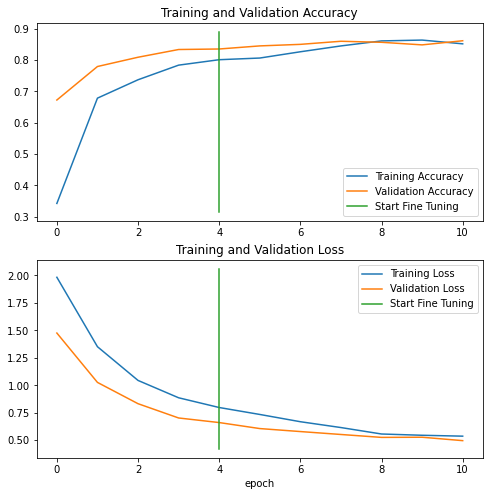

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

İnce ayardan sonra eğriler doğru yöne gidiyor gibi görünüyor. Ancak unutmayın, ince ayarın genellikle daha büyük miktarda veriyle en iyi sonucu verdiğine dikkat edilmelidir.

#### Model 4: Mevcut Bir Modelde Tüm Verilerin İnce Ayarını Yapma (Fine Tuning)

Bir modelin ince ayarının genellikle daha fazla veriyle nasıl çalıştığı hakkında yeterince konuştuk, hadi deneyelim.

10 yemek sınıfı veri setimizin tam sürümünü indirerek başlayacağız.

In [ ]:
!gdown --id 1EJHNCG19hJG6XwIFxt2rpah-Q1Ikrbxw
unzip_data("10_food_classes_all_data.zip")

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
walk_through_dir("10_food_classes_all_data")

Şimdi görüntüleri tensör veri kümelerine çevireceğiz.

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Bu iyi görünüyor. Çalışmak için eğitim sınıflarında 10 kat daha fazla görselimiz var.

Test veri seti, önceki deneylerimiz için kullandığımızla aynıdır.

Şimdi olduğu gibi, model_2'miz verilerin yüzde 10'unda ince ayar yapıldı, bu nedenle tüm verilerde ince ayar yapmaya başlamak ve deneylerimizi tutarlı tutmak için 5 epoch'tan sonra kontrol ettiğimiz ağırlıklara geri döndürmemiz gerekiyor.

Bunu göstermek için önce mevcut model_2'yi değerlendireceğiz.


In [ ]:
model_2.evaluate(test_data)

Bunlar, result_fine_tune_10_percent ile aynı değerlerdir.

In [ ]:
results_fine_tune_10_percent

Şimdi modeli kaydedilen ağırlıklara geri döndüreceğiz.

In [ ]:
model_2.load_weights(checkpoint_path)

Ve sonuçlar, result_10_percent_data_aug ile aynı olmalıdır.

In [ ]:
model_2.evaluate(test_data)

In [ ]:
results_10_percent_data_aug

Pekala, önceki adımlar oldukça kafa karıştırıcı görünebilir ancak tek yaptığımız:

1. Verilerin %10'unda (tüm temel model katmanları donmuş halde) 5 epoch için bir özellik çıkarma transferi öğrenme modeli eğitildi ve ModelCheckpoint kullanılarak modelin ağırlıkları kaydedildi.
2. Temel modelin ilk 10 katmanı dondurulmamış olarak, 5 epoch daha için aynı %10'luk veri üzerinde aynı modelde ince ayar yapıldı.
3. Her seferinde sonuçları ve eğitim günlüklerini kaydedildi.
4. 2 ile aynı adımları ancak tüm verilerle yapmak için modeli 1'den yeniden yükledi.

2 ile aynı adımlar?
> Evet, temel modelin son 10 katmanına tam veri seti ile 5 dönem daha ince ayar yapacağız ama önce kendimize hangi katmanların eğitilebilir olduğunu hatırlatalım.

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

İyi görünüyor! Son 10 katman eğitilebilir (dondurulmamış). İnce ayara başlamadan önce yapmamız gereken bir adım daha var.

Ne olduğunu hatırlıyor musun?

Sana bir ipucu vereceğim. Ağırlıkları modelimize yeniden yükledik ve modellerimizde her değişiklik yaptığımızda ne yapmamız gerekiyor?

Onları yeniden derleyin! Bu daha önce olduğu gibi olacak.

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

Pekala, tüm verilerde ince ayar yapma zamanı!

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

> 🔑 Not: Eğitim epoch başına daha uzun sürdü, ancak bu mantıklı çünkü öncekinden 10 kat daha fazla eğitim verisi kullanıyoruz.

Tüm test verilerini değerlendirelim.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

Güzel! Tüm verilerle yapılan ince ayar, modelimize hız kazandırmış gibi görünüyor, eğitim eğrileri nasıl görünüyor?

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Görünüşe göre bu ekstra veriler yardımcı oldu! Bu kıvrımlar harika görünüyor. Ve daha uzun süre antrenman yaparsak, gelişmeye devam edebilirler.

## Deney Verilerimizi TensorBoard'da Görüntüleme

Şu anda deneysel sonuçlarımız defterimizin her yerine dağılmış durumda. Bunları birisiyle paylaşmak istersek, bir sürü farklı grafik ve metrik alacaklardır... eğlenceli bir zaman değil.

Ama tahmin et ne oldu?

Yardımcı fonksiyonumuz `create_tensorflow_callback()` ile yaptığımız TensorBoard geri çağrısı sayesinde modelleme deneylerimizi sürekli takip ediyoruz.

Bunları TensorBoard.dev'e yükleyip kontrol etmeye ne dersiniz?

Tensorboard dev upload komutu ile deneylerimizin kaydedildiği dizine iletebiliriz.

> 🔑 Not: TensorBoard.dev'e yüklediğiniz her şeyin herkese açık hale geleceğini unutmayın. Paylaşmak istemediğiniz kayıtları varsa yüklemeyin.

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot

Sonuçları TensorBoard.dev'e yükledikten sonra, deneylerimizi görüntülemek ve karşılaştırmak ve gerekirse sonuçlarımızı başkalarıyla paylaşmak için kullanabileceğimiz paylaşılabilir bir bağlantı alırız.

> 🤔 Soru: Hangi model en iyi performansı gösterdi? Sizce bu neden? İnce ayar nasıl gitti?

Tensorboard dev list komutunu kullanarak önceki tüm TensorBoard.dev deneylerinizi bulmak için.

In [ ]:
!tensorboard dev list

Ve önceki bir denemeyi kaldırmak (ve genel görüntülemeden silmek) istiyorsanız şu komutu kullanabilirsiniz:

In [ ]:
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q